In [1]:
import glob

import torch
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader

from inpainting import transforms
from inpainting.inpainting.deepfillv1.model import DeepFillV1Model
from inpainting.inpainting.kernel_inpainting import Inpainter
from inpainting.inpainting.region_fill import inpaint
from inpainting.load import MergeDataset, SequenceDataset
from inpainting.utils import dilate, annotation_to_mask
from inpainting.visualize import flow_tensor_to_image_tensor
from inpainting.visualize import tensor_to_pil_image

In [2]:
images_dataset = SequenceDataset(
    list(glob.glob(f'../data/interim/DAVIS/ResizedJPEGImages/tennis')),
    'image',
    sequence_length=2
)
masks_dataset = SequenceDataset(
    list(glob.glob(f'../data/interim/DAVIS/ResizedAnnotations/tennis')),
    'annotation',
    sequence_length=2,
    transform=transforms.Lambda(annotation_to_mask)
)
dataset = MergeDataset([images_dataset, masks_dataset], transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
images, masks = next(iter(data_loader))
prev_image, curr_image = images
prev_mask, curr_mask = masks

In [4]:
_, _, w, h = curr_image.size()
prev_image = interpolate(prev_image, size=[w // 64 * 64, h // 64 * 64]).cuda()
curr_image = interpolate(curr_image, size=[w // 64 * 64, h // 64 * 64]).cuda()
prev_mask = dilate(interpolate(prev_mask, size=[w // 64 * 64, h // 64 * 64]), 5, 3).cuda()
curr_mask = dilate(interpolate(curr_mask, size=[w // 64 * 64, h // 64 * 64]), 5, 3).cuda()

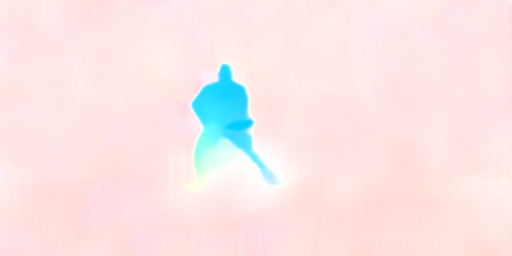

In [5]:
from inpainting.flow.flownet2.model import FlowNet2Model

model = FlowNet2Model('../models/flow/flownet2/FlowNet2_checkpoint.pth.tar').cuda()
flow = model(prev_image, curr_image).detach()
tensor_to_pil_image(flow_tensor_to_image_tensor(flow))


7100


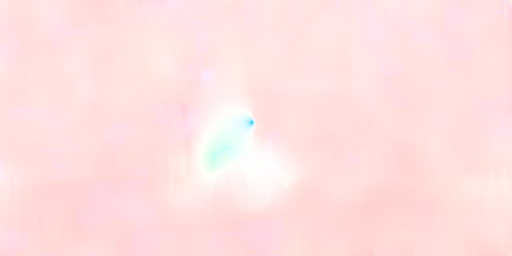

In [6]:
from inpainting.inpainting.kernel_inpainting import Inpainter

algorithm = Inpainter()
result = algorithm(flow, prev_mask)
tensor_to_pil_image(flow_tensor_to_image_tensor(result))

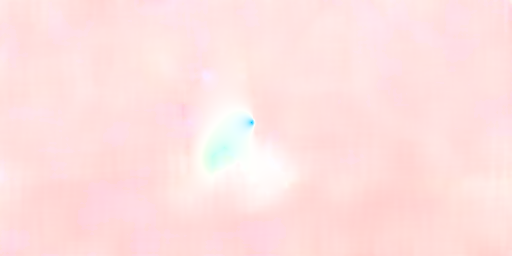

In [7]:
from inpainting.inpainting.region_fill import inpaint

result = inpaint(flow, prev_mask)
tensor_to_pil_image(flow_tensor_to_image_tensor(result))
